In [3]:
# author: Jhonathan Romero Fontalvo
#         BK and JW transformations (April 30, 2015)
#         Revised version (August 11, 2016)
#         Circuits (August 30, 2015)
#         Commutators (December 2, 2015)
#         Routines to write inputs for qHipster (December 13, 2015)
#         Revised version (December 14, 2016)

import time
import numpy as np
import scipy
from scipy.optimize import minimize
import warnings
#import commutators
import scipy.sparse
import scipy.optimize
import scipy.sparse.linalg
from itertools import combinations
from sys import argv
import resource
import itertools
import commutators #(Ryan Babbush)
from qutip import *
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline

## Symbolic Bravyi-Kitaev (BK) and Jordan-Wigner (JW) transformations.

The next cells have routines that perform the tasks requires for the Jordan-Wigner and the Bravyi-Kitaev transformation.

In [4]:
def generateBKSets(qubits):
    """ Generate the sets parity (P), update (U), flip (F) and remaining (R) sets
        required for the BK transformation.
        
        References: Seeley et al. JCP, 137, 224109 (2012) 
        
        Returns
        -------
            Lists of P, U, F and R for n qubits. Handles up to 10 qubits.
    """
    dic={0:1,1:2,2:4,3:8,4:16,5:32,6:64,7:128,8:256,9:512,10:1024}
    for n in range(0,11):
        if dic[n]>=qubits:
            power2=n
            break
    beta=1.
    invbeta=1.
    size=2**power2
    pi=np.zeros((size,size))
    for n in range(0,size):
        pi[n,0:n]=1
    I = np.array([[1, 0], [0, 1]])
    for n in range(0,power2):
        l1=2**n
        beta=np.kron(I,beta)
        invbeta=np.kron(I,invbeta)
        for m in range(0,l1):
            beta[2*l1-1,m]=1.0
        invbeta[2*l1-1,l1-1]=1.0
    #print np.linalg.inv(beta)
    parity=np.remainder(np.dot(pi,invbeta),2)
    P={}
    for n in range(0,qubits):
        s=[]
        for m in range(0,n):
            if parity[n,m]==1:
                s.append(m)
        P[n]=s
    R={}
    for n in range(0,qubits):
        s=[]
        for m in range(0,n):
            if parity[n,m]==1:
                s.append(m)
        R[n]=s
    F={}
    for n in range(0,qubits):
        set=[]
        for m in range(0,n):
            if invbeta[n,m]==1:
                set.append(m)
        F[n]=set
    U={}
    for n in range(0,qubits):
        set=[]
        for m in range(n+1,qubits):
            if beta[m,n]==1:
                set.append(m)
        U[n]=set
    for n in range(0,qubits):
        for x in F[n]:
            if x in R[n]:
                R[n].remove(x)
    return beta,P,U,F,R

## Class term

In [5]:
def chunkIt(seq, num):
    """Create chunks of a list"""
    avg = len(seq) / float(num)
    out = []
    last = 0.0
    
    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg
    return out

class term:
    """ Class Term: Defines symbolically a product of Pauli Matrices
        The term is saved as a dictionary, with each qubit having a list of terms
    """
    def __init__(self,nqubits,alpha=0.0):
        string={}
        for n in range(0,nqubits):
            string[n]=['I']
        self.c = 1.0 # coefficient of the term
        self.pl = string # dictionary containing n strings, one per each qubit
        self.matrix=[] # matrix form of the term
        self.l=nqubits # length: number of qubits
        self.alpha=alpha #
        
    def reduceTerm(self):
        """
            Reduces a product of Pauli Matrices
        """
        dic1={'ZZ':'I','YY':'I','XX':'I','II':'I','XY':'Z','XZ':'Y','YX':'Z','YZ':'X','ZX':'Y',
              'ZY':'X','IX':'X','IY':'Y','IZ':'Z','ZI':'Z','YI':'Y','XI':'X'}
        dic2={'ZZ':1.0,'YY':1.0,'XX':1.0,'II':1.0,'XY':1.0j,'XZ':-1.0j,'YX':-1.0j,'YZ':1.0j,'ZX':1.0j,
              'ZY':-1.0j,'IX':1.0,'IY':1.0,'IZ':1.0,'ZI':1.0,'YI':1.0,'XI':1.0}
        factor=1.0 
        for x in self.pl:
            t=self.pl[x]
            length=len(t)
            while length>1:
                pair=''.join(t[:2])
                del t[:2]
                t.insert(0,dic1[pair])
                factor=factor*dic2[pair]
                length=len(t)
            self.pl[x]=t
        self.c=factor*self.c
    
    def printTerm(self):
        """
            Routine to print term. N 1.
            
            Returns
            -------
                Coefficient and string representing the term
        """
        vprint=[]
        for x in self.pl:
            vprint += self.pl[x]
            vprint += str(x)
        vprint=''.join(vprint)
        return self.c,vprint
    
    def printTerm2(self):
        """
            Routine to print term. N 2.
            
            Returns
            -------
                Coefficient and string representing the term
        """
        vprint=[]
        for x in self.pl:
            vprint += self.pl[x]
        return self.c,vprint
    
    def printTerm3(self):
        """
            Routine to print term. N 3.
            
            Returns
            -------
                Coefficient and string representing the term
                In addition counds the number of cnot, swap, single qubits and control z
                gates required to implement the evolution of the terms.
                Used to estimate number of gates for the superconducting qubit devices of John Martinis. 
        """
        vprint=[]
        counter=0
        n_swaps=0
        n_x=0; n_y=0
        maxi=0
        mini=self.l
        for x in self.pl:
            if self.pl[x] != ['Y']:
                n_y += 1
            if self.pl[x] != ['X']:
                n_x += 1
            if self.pl[x] != ['I']:
                counter=counter+1
                vprint += self.pl[x]
                if x>maxi:
                    maxi=x
                if x<mini:
                    mini=x
                vprint += str(x)
            elif self.pl[x] == ['I']:
                vprint += [' ']
        for n in range(mini,maxi+1):
            if self.pl[n] == ['I']:
                n_swaps += 2
        vprint=''.join(vprint)
        n_cnots=2*(maxi-mini)-n_swaps
        sqcount=n_x*2+n_y*2+2*n_cnots+6*n_swaps
        czcount=1*(n_cnots)+3*n_swaps
        return self.c,vprint,8-counter,n,sqcount,czcount,n_swaps,n_cnots
    
    def printTerm4(self):
        """
            Routine to print term. N 4.
            
            Returns
            -------
                Coefficient, string representing the term in latex notation and number of 
                Pauli matrices in the string
        """
        vprint=[]
        counter=0
        for x in self.pl:
            if self.pl[x] != ['I']:
                counter=counter+1
                vprint += '\sigma_'
                cosa=self.pl[x][0]
                vprint += self.pl[x]
                vprint += '^'
                vprint += str(x)
        vprint=''.join(vprint)
        return self.c,vprint,counter

    def printCircuit(self,f1):
        """
            Returns
            -------
                Circuit implementation of exp(-i\theta Term) using CNOTs and single rotations

        """
        list_of_qubits = []
        coefficient = self.c.imag
        if coefficient == 0.0:
            coefficient = self.c.real
        for x in self.pl:
            if self.pl[x] != ['I']:
                list_of_qubits.append(x)
            if self.pl[x] == ['Y']:
                f1.write('\tRx\tq'+str(x)+'\n')
            elif self.pl[x] == ['X']:
                f1.write('\tH\tq'+str(x)+'\n')
        for n in range(1,len(list_of_qubits)):
            f1.write('\tcnot\tq'+str(n)+',q'+str(n+1)+'\n')
        f1.write('\tRz\tq'+str(list_of_qubits[-1])+'\t'+str(coefficient)+'\n')
        for n in range(1,len(list_of_qubits))[::-1]:
            f1.write('\tcnot\tq'+str(n-1)+',q'+str(n)+'\n')
        for x in self.pl:
            if self.pl[x] == ['Y']:
                f1.write('\tRxt\tq'+str(x)+'\n')
            elif self.pl[x] == ['X']:
                f1.write('\tH\tq'+str(x)+'\n')

    def getListOfOperations(self):
        """
                Get the information necessary to print the string in the 
                format proposed by Gian for qHipster
        """
        list_of_qubits = []
        list_of_operations = []
        for x in self.pl:
            if self.pl[x] != ['I']:
                list_of_qubits.append(x)
                if self.pl[x] == ['X']:
                    list_of_operations.append(1)
                elif self.pl[x] == ['Y']:
                    list_of_operations.append(2)
                elif self.pl[x] == ['Z']:
                    list_of_operations.append(3)
        self.nonIcount = len(list_of_qubits)
        self.list_of_qubits = list_of_qubits
        self.list_of_operations = list_of_operations
    
    def printString(self,f1):
        """
                Print the string in the 
                format proposed by Gian for qHipster
        """
        if not hasattr(self, 'nonIcount'):
            self.getListOfOperations()
        coefficient = self.c.imag
        #print(coefficient)
        if coefficient == 0.0:
            coefficient = self.c.real
            #print(coefficient)
        f1.write('{0:.8f}\t{1}\t{2}\n'.format(coefficient,' '.join(str(x) for x in self.list_of_qubits),
                                              ' '.join(str(x) for x in self.list_of_operations)))

    def getMatrix(self):       
        """
            Routine to print term. N 4.
            
            Returns
            -------
                A qutip quantum object (QUTIP) that corresponds to the Pauli term
        """
        pauli={'I':identity(2),'X':sigmax(),'Y':sigmay(),'Z':sigmaz()}
        counter=-1
        l=[]
        for t in self.pl:
            counter += 1
            l.append(pauli[self.pl[t][0]])
        m = tensor(l)
        self.matrix=self.c*m
        return self.c*m
    
def simplifyTerms(products):
    """        
    Input: products, a list of terms with the same size (number of qubits), that might have repeated terms.
    
    Returns
    -------
        A simplified list of terms, without repetitions.    
        
    Note
    -------
        The routine also discards terms with small coefficients.
        THIS ROUTINE IS PRETTY SLOW, WE MUST MAKE IT MORE EFFICIENT
        CHECK FOR ALGORITHMS TO COMPARE LIST ELEMENTS
    """
    error=10**(-12) # threshold to discard terms
    ss=[]
    products2=[]
    indexes=range(0,len(products))
    counter=0
    removed=[]
    for p in indexes:
        if (p in removed)==False:
            s=[]
            s += [p]; removed += [p]; counter +=1
            for q in indexes:
                if (q in removed)==False:
                    addTerm = True
                    for x in products[p].pl:
                        if products[p].pl[x] != products[q].pl[x]:
                            addTerm = False
                            break
                    if addTerm:
                        s += [q]; removed += [q]; counter +=1
            ss += [s]
        if counter == len(products):
            break
    # calculating sums and eliminating repeated terms
    for x in ss:
        value=0.0
        for y in x:
            value=value+products[y].c
        if abs(value)>error:
            products[x[0]].c=value
            products2.append(products[x[0]])
    del products
    return products2

def returnBKform(operator,P,U,F,R):
    """        
    Input: operator of the form [i,j,-k,-l] that represents a^{/dag}_i a^{/dag}_j a_k a_l. Any length.
            P, U, F and R sets of the corresponding size.

    Returns
    -------
        The representation of the operator in the BK form
    
    """
    # P, U and F must have the same number of elements = nqubits
    l=len(operator)
    size=2*l
    nqubits=len(P)
    BKform=[]
    counter=-1
    for a in operator:
        counter += 1
        s1=term(nqubits)
        s2=term(nqubits)
        j=abs(a)-1
        # case j is even
        if j%2==0:
            s1.pl[j] += 'X'
            #print U[j], P[j], R[j]
            for k in U[j]:
                s1.pl[k] += 'X'
                #print k
            for k in P[j]:
                #print k
                s1.pl[k] += 'Z'
            s2.pl[j] += 'Y'
            for k in U[j]:
                s2.pl[k] += 'X'
                #print k
            for k in P[j]:
                s2.pl[k] += 'Z'
                #print k
            # annihilator
            if a<0:
                s1.c=0.5
                s2.c=0.5j
            # creator
            elif a>0:
                s1.c=0.5
                s2.c=-0.5j              
            BKform += [s1]
            BKform += [s2]
            s1.reduceTerm()
            s2.reduceTerm()
        # case j is odd
        elif j%2==1:
            s1.pl[j] += 'X'
            #print U[j], P[j], R[j]
            for k in U[j]:
                s1.pl[k] += 'X'
                #print k
            for k in P[j]:
                s1.pl[k] += 'Z'
                #print k
            s2.pl[j] += 'Y'
            for k in U[j]:
                s2.pl[k] += 'X'
                #print k
            for k in R[j]:
                s2.pl[k] += 'Z'
                #print k
            # annihilator
            if a<0:
                s1.c=0.5
                s2.c=0.5j
            # creator
            elif a>0:
                s1.c=0.5
                s2.c=-0.5j 
            s1.reduceTerm()
            s2.reduceTerm()
            BKform += [s1]
            BKform += [s2]
        #print s1.printTerm()
        #print s2.printTerm()
        del s1; del s2
    products=[]
    iterables = chunkIt(range(size), size/2)
    counter = 0
    for element in itertools.product(*iterables):
        counter += 1
        s=term(nqubits)
        for t in element:
            for k in range(0,nqubits):
                s.pl[k] += BKform[t].pl[k]
            s.c=s.c*BKform[t].c
        s.reduceTerm()
        products += [s]
        del s
    # finding terms that are equivalent
    products2=simplifyTerms(products)
    return products2

def returnJWform(operator,nqubits):
    """        
    Input: operator of the form [i,j,-k,-l] that represents a^{/dag}_i a^{/dag}_j a_k a_l. Any length.
            Number of qubits. 

    Returns
    -------
        The representation of the operator in the JW form
    
    """
    l=len(operator)
    size=2*l
    BKform=[]
    counter=-1
    for a in operator:
        counter += 1
        s1=term(nqubits) 
        s2=term(nqubits)
        j=abs(a)-1
        # case j is even
        s1.pl[j] += 'X'
        #print U[j], P[j], R[j]
        for k in range(0,j):
            s1.pl[k] += 'Z'
        s2.pl[j] += 'Y'
        for k in range(0,j):
            s2.pl[k] += 'Z'
        # annihilator
        if a<0:
            s1.c=0.5
            s2.c=0.5j
        # creator
        elif a>0:
            s1.c=0.5
            s2.c=-0.5j 
        s1.reduceTerm()
        s2.reduceTerm()
        BKform += [s1]
        BKform += [s2]
        #print s1.printTerm()
        #print s2.printTerm()
        del s1; del s2
    products=[]
    iterables = chunkIt(range(size), size/2)
    counter = 0
    for element in itertools.product(*iterables):
        counter += 1
        s=term(nqubits)
        for t in element:
            for k in range(0,nqubits):
                s.pl[k] += BKform[t].pl[k]
            s.c=s.c*BKform[t].c
        s.reduceTerm()
        products += [s]
        del s
    # finding terms that are equivalent
    products2=simplifyTerms(products)
    return products2


## Hamiltonian and ansatz manipulation

Functions that transform a Hamiltonian in second quantization to sum of strings of Pauli Matrices. 

In [6]:
def reduceHamiltonian(hamiltonian):
    """        
    Input: Hamiltonian with repeated terms. 

    Returns
    -------
        Hamiltonian without repeated terms.
        
    Note
    -------
        THIS ROUTINE NEEDS ACCELERATION
    
    """    
    check_term={}
    result=True
    new_nqubits=0
    # remove qubit if the operations for all of them are identities
    for n in range(0,hamiltonian[0].l):
        counter=0
        for x in hamiltonian:
            if x.pl[n]==['I']:
                counter+=1
        if counter==len(hamiltonian):
            check_term[n]=False
        else:
            check_term[n]=True
        result=result*check_term[n]
        new_nqubits += check_term[n]
    products=[]
    print (check_term)
    if result==0:
        for x in hamiltonian:
            y=term(int(new_nqubits))
            counter=-1
            y.c=x.c
            for n in range(0,len(check_term)):
                if check_term[n]==True:
                    counter += 1
                    y.pl[counter]=x.pl[n]
            products.append(y)
        #products2=simplifyTerms(products)
        return products
    else:
        return hamiltonian

def getBKHamiltonian(coefficients,terms,P,U,F,R):
    """        
    Input: A second quantized hamiltonian represented as a list of coeffficients 
            and terms in second quantization. P, U, F and R sets
            for a given number of qubits.
    
    The notation for terms in second quantization is: [i,j,-k,-l] 
    that represents a^{/dag}_i a^{/dag}_j a_k a_l. Any length.

    Returns
    -------
        The Hamiltonian in BK form
    
    """
    products=[]
    conteo=0
    start_time = time.time()
    for c,t in zip(coefficients,terms):    
        #print c,t
        cosa = returnBKform(t,P,U,F,R)
        conteo=conteo+len(cosa)
        for element in cosa:
            element.c=c*element.c
            #print element.printTerm()
        products.extend(cosa)
    # finding terms that are equivalent
    total_time = time.time() - start_time
    print("Time for transformation:",total_time)
    print("length of products:",len(products))
    start_time = time.time()
    products2=simplifyTerms(products)
    total_time = time.time() - start_time
    print("Time for simplification:",total_time)
    print("length of products2:",len(products2))
    return products2  

def getJWHamiltonian(coefficients, terms, nqubits, num=20):
    """        
    Input: A second quantized hamiltonian represented as a list of coeffficients 
            and terms in second quantization. Number of qubits. 
    
    The notation for terms in second quantization is: [i,j,-k,-l] 
    that represents a^{/dag}_i a^{/dag}_j a_k a_l. Any length.

    Returns
    -------
        The Hamiltonian in JW form
    
    """
    error=10**(-12)
    #coefficients, terms = commutators.GetHamiltonianTerms(molecule, basis, add_conjugates=True)
    products=[]
    conteo=0
    start_time = time.time()
    for c,t in zip(coefficients,terms):    
        #print c,t
        cosa = returnJWform(t,nqubits)
        conteo=conteo+len(cosa)
        for element in cosa:
            element.c=c*element.c
            #print element.printTerm()
        products.extend(cosa)
    # finding terms that are equivalent
    total_time = time.time() - start_time
    print("Time for transformation:",total_time)
    print("length of products:",len(products))
    start_time = time.time()
    #chunks = chunkIt(products, num)
    #products2 = []
    #for chunk in chunks:
    #    chunk2 = simplifyTerms(chunk)
    #    products2.extend(chunk)
    products3 = simplifyTerms(products)
    total_time = time.time() - start_time
    print("Time for simplification:",total_time)
    print("length of products3:",len(products3))
    return products3

def createExcitations(nocc,total,N):
    """
        Return 
        ------
            Create excitation operators up to order N for a given number of occupied orbitals (nocc)
            and total orbitals (total)
    """
    occ=range(1,nocc+1)
    vir=range(nocc+1,total+1)
    operators=[]
    for n in range(1,N+1):
        for cosa1 in itertools.combinations(occ,n):
            for cosa2 in itertools.combinations(vir,n):
                cosita=[]
                cosita.extend(cosa2[::-1])
                cosita.extend([x * -1 for x in cosa1[::-1]])
                operators.append(cosita)
    return operators

In [7]:
def checkCommutation(term1,term2):
    """        
    Input: 2 TERMS
    Returns
    -------
        Logical value. False or TrueHamiltonian without repeated terms.
    Note
    -------
        THIS ROUTINE NEEDS ACCELERATION
    """    
    nqubits1=max(term1.l,term2.l)
    nqubits2=min(term1.l,term2.l)
    product1=term(nqubits1)
    product2=term(nqubits1)
    for x in range(0,nqubits2):
        product1.pl[x] += term1.pl[x]
        product1.pl[x] += term2.pl[x]
        product2.pl[x] += term2.pl[x]
        product2.pl[x] += term1.pl[x]
    product1.reduceTerm(); product2.reduceTerm();
    commute=False
    if product1.c==product2.c:
        commute=True
    return commute

def checkCommutation2(term1,term2):
    """        
    Input: 2 TERMS

    Returns
    -------
        Logical value. False or TrueHamiltonian without repeated terms.
        
    Note
    -------
        THIS SHOULD BE FASTER
    
    """    
    if term1.l != term2.l:
        raise ValueError('The Pauli strings to be compared must act on the same number of qubits')
    counter = 0
    for a, b in zip(term1.pl,term2.pl):
        if term1.pl[a]!=term2.pl[b] and term1.pl[a]!=['I'] and term2.pl[b]!=['I']:
            #print(a,b,term1.pl[a],term2.pl[b])
            counter += 1
    if counter%2 == 1:
        commute = False
    else:
        commute = True
    #print(counter)
    return commute

def getHam_JW(molecule,basis,path,num=20):
    """        
    Gets a hamiltonian from file. Uses commutators.py

    Returns
    -------
        Hamiltonian in JW form
    """  
    fci_energy, repulsion, coefficients, terms = commutators.GetHamiltonianTerms(molecule, basis, add_conjugates=True, path=path)
    N = commutators.OrbitalCount(terms)
    hamiltonian=getJWHamiltonian(coefficients,terms,N,num)
    return hamiltonian

def getHam_BK(molecule,basis,path):
    """        
    Gets a hamiltonian from file. Uses commutators.py

    Returns
    -------
        Hamiltonian in BK form
    """  
    fci_energy, repulsion, coefficients, terms = commutators.GetHamiltonianTerms(molecule, basis, add_conjugates=True, path=path)
    N = commutators.OrbitalCount(terms)
    hamiltonian=getBKHamiltonian(coefficients,terms,N)
    return hamiltonian

def getHamiltonianObject(ham):
    """        
    Gets a qutip quantum object from a Hamiltonian consisting of a list of objects of type term. 
    
    Returns
    -------
        Qobj
    """  
    qobject = ham[0].getMatrix()
    for n in range(1,len(ham)):
        qobject = qobject + ham[n].getMatrix()
    return qobject

#compBasis={'1':basis(2,1),'0':basis(2,0)}
#pauli={'I':qeye(2),'Z':sigmaz(),'X':sigmax(),'Y':sigmay()}

def genNqubitState(state):
    l=[]
    for x in state:
        l.append(compBasis[x])
    result=tensor(l)
    return result    

In [8]:
def diffJW(example1,nqubits):
    """
    Returns
    -------
        JW form of an antihermitian UCC operator
    """
    example2=example1[::-1]
    example2 = [x * -1 for x in example2]
    expression=getJWHamiltonian([1.0,-1.0],[example1,example2],nqubits)
    return expression

def diffBK(example1,P,U,F,R):
    """
    Returns
    -------
        BK form of an antihermitian UCC operator
    """
    example2=example1[::-1]
    example2 = [x * -1 for x in example2]
    expression=getBKHamiltonian([1.0,-1.0],[example1,example2],P,U,F,R)
    return expression

## Routines to print circuits for qHipster

In [1]:
def orderAndPrintHamiltonian(hamiltonian,name):
    """
        Print hamiltonian using Gian's convention:
        - First line has n+1 numbers, q_i. q_i is the number of terms
        with length i.
        - Lines describe:
            coefficient \t qubits \t pauli strings (1=X,2=Y,Z=3)
        Example: -0.98 Z1Z3X4Y5
        -0.98 \t 1 3 4 5 \t 3 3 1 2
        Strings are ordered from the shortest to the longest
    """
    f1 = open(name,'w')
    lengthCount = []
    for h in hamiltonian:
        h.getListOfOperations()
        lengthCount.append(h.nonIcount)
    sort_index = np.argsort(np.array(lengthCount))
    ks = np.zeros(hamiltonian[0].l+1)
    for n in range(hamiltonian[0].l+1):
        ks[n]=lengthCount.count(n)
    f1.write('{0}\n'.format(' '.join(str(int(k)) for k in ks)))
    for x in sort_index:
        hamiltonian[x].printString(f1)
    print(sort_index)
    print(lengthCount)
    f1.close()
    
def writeUCC(coefficients,ham_terms,f1,nqubits,mapping='JW'):
    """
        Takes a set of coefficients and excitation operators and 
        return the corresponding circuit using CNOTs and arbitrary qubit rotations
    """
    f1.write('--- Ansatz preparation ---\n')
    n=-1
    for c,t in zip(coefficients, ham_terms):
        if mapping=='JW':
            subterms = diffJW(t,nqubits)
        if mapping=='BK':
            subterms = diffBK(t,nqubits)
        n+=1
        f2.write('b{0}\t{1:.12f}\n'.format(n,c))
        for subterm in subterms:
            print(subterm)
            subterm.printCircuit(f1,'b'+str(n))

def writeQASM(coefficients,ham_terms,nqubits,filepath,mapping='JW'):
    """
        Write qasm circuit of MPS+GUCCI for qHipster
    """
    f1 = open(filepath+'.qasm','w')
    f2 = open(filepath+'-b.out','w')
    n=-1
    f1.write('--- initialization ---\n')
    for n in range(8):
        f1.write('\tqubit\tq'+str(n)+',0\n')
    f1.write('--- MPS preparation ---\n')
    f1.write('\tRy\tq0\ta5\n')
    f1.write('\tcnot\tq0,q7\n')

    f1.write('\tRy\tq6\ta4\n')
    f1.write('\tcnot\tq0,q6\n')
    f1.write('\tRy\tq6\t-a4\n')    
    f1.write('\tcnot\tq0,q6\n')
    
    f1.write('\tX\tq0\n')    
    f1.write('\tcnot\tq0,q5\n')    
    f1.write('\tX\tq0\n')    

    f1.write('\tRy\tq4\ta1\n')
    f1.write('\tcnot\tq0,q4\n')
    f1.write('\tRy\tq4\t-a1\n')
    f1.write('\tcnot\tq0,q4\n')

    f1.write('\tRy\tq4\ta2\n')
    f1.write('\tcnot\tq0,q4\n')
    f1.write('\tRy\tq4\t-a2\n')
    f1.write('\tcnot\tq0,q4\n')

    f1.write('\tRy\tq0\ta0\n')
    f1.write('\tcnot\tq0,q3\n')

    f1.write('\tcnot\tq0,q2\n')

    f1.write('\tX\tq0\n')    
    f1.write('\tcnot\tq0,q1\n')    

    writeUCC(coefficients,ham_terms, f1, nqubits, mapping)

    f1.close()
    
    
def writeHamiltonian(coefficients,ham_terms,filepath):
    hamiltonian = getJWHamiltonian(coefficients, ham_terms, 8)
    orderAndPrintHamiltonian(hamiltonian,filepath+'.ham')
    f1.close()

## Routines to divide Hamiltonian into commuting groups

In [29]:
def canBeMerge(group1,group2):
    merge = True
    for x in group1:
        for y in group2:
            #print("Terms:",x.printTerm(),y.printTerm())
            if checkCommutation(x,y)==False:
                merge = False
                break
        else:
            continue
        break
    return merge

def canBeMerge2(group1,group2):
    merge = True
    for x in group1:
        for y in group2:
            #print("Terms:",x.printTerm(),y.printTerm())
            if checkCommutation2(x,y)==False:
                merge = False
                break
        else:
            continue
        break
    return merge

def sweepStep(hamGroups):
    length = len(hamGroups)
    for n in range(length):      
        x = hamGroups[n]
        for m in range(n+1,length):  
            y = hamGroups[m]
            if canBeMerge(x,y) == True:
                #print(n,m,"YES")
                y.extend(x)
                hamGroups.remove(x)
                break
        else:
            continue
        break

def sweepStep2(hamGroups):
    length = len(hamGroups)
    for n in range(length):      
        x = hamGroups[n]
        for m in range(n+1,length):  
            y = hamGroups[m]
            if canBeMerge2(x,y) == True:
                #print(n,m,"YES")
                y.extend(x)
                hamGroups.remove(x)
                break
        else:
            continue
        break
        
def groupHamiltonian(ham):
    hamGroups = []
    for x in ham:
        hamGroups.append([x])
    start_time = time.time()
    nelements = len(hamGroups)
    nelements2 = 0
    while nelements>nelements2:
        nelements = len(hamGroups)
        sweepStep(hamGroups)
        nelements2 = len(hamGroups)
        #print(nelements,nelements2)
    total_time = time.time() - start_time
    total_memory = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1000
    return hamGroups, total_time, total_memory

def groupHamiltonian(ham):
    hamGroups = []
    for x in ham:
        hamGroups.append([x])
    start_time = time.time()
    nelements = len(hamGroups)
    nelements2 = 0
    while nelements>nelements2:
        nelements = len(hamGroups)
        sweepStep2(hamGroups)
        nelements2 = len(hamGroups)
        #print(nelements,nelements2)
    total_time = time.time() - start_time
    total_memory = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1000
    return hamGroups, total_time, total_memory

## Hubbard hamiltonians

In [11]:
def constructSymbolicHubbard2(hdim,vdim,t,U):
    """
        Generates the Hamiltonian for a Hubbard model in a grid structure
        with hdim and vdim sites in the horizontal and the vertical dimensions, respectively
        
        The system in periodic in the horizontal dimension and 
        open in the vertical dimension
        
        Inputs: number of sites (nsites), t and U (parameters of the model)
        
        t: hopping parameters. A positive t must be provided
        U: repulsion parameters
        
        
    """
    hdim = hdim*2
    nqubits = vdim*hdim
    # first horizontal line of sites
    firstLine = range(1,hdim-1)
    spinDownList = [x for x in firstLine if x % 2 == 1]
    coefficients=[]
    operators=[]
    # Generating the horizontal contributions to the hamiltonian
    for j in range(0,vdim):
        offset = j*hdim
        for i in spinDownList:
            #print(i)
            operators.append([i+offset,-i-2-offset])
            coefficients.append(-t)
            operators.append([i+1+offset,-i-3-offset])
            coefficients.append(-t)            
        # periodic boundary conditions
        if hdim > 2:
            operators.append([hdim-1+offset,-1-offset])
            coefficients.append(-t)
            operators.append([hdim+offset,-2-offset])
            coefficients.append(-t)     
    #print("spinDownList",spinDownList)
    #print("horizontal contributions:",operators)

    # Generating the vertical contributions to the hamiltonian
    # open boundary conditions
    firstLine = range(1,hdim+1)
    spinDownList = [x for x in firstLine if x % 2 == 1]
    #print("spinDownList",spinDownList)
    for j in range(1,vdim):
        offset1 = (j-1)*hdim
        offset2 = j*hdim
        for i in spinDownList:
            #print(i)
            operators.append([i+offset1,-i-offset2])
            coefficients.append(-t)
            operators.append([i+1+offset1,-i-1-offset2])
            coefficients.append(-t)            
    #print("vertical contributions:",operators)
    
    # repulsion terms
    allQubits = range(1,nqubits+1)
    spinDownListAll = [x for x in allQubits if x % 2 == 1]
    for i in spinDownListAll:
        operators.append([i,-i,i+1,-i-1])
        coefficients.append(U)
    
    #print("repulsion contributions:",operators)
    return operators, coefficients, nqubits

compBasis={'1':basis(2,1),'0':basis(2,0)}
pauli={'I':qeye(2),'Z':sigmaz(),'X':sigmax(),'Y':sigmay()}

def constructNumberOperator(nqubits,transformation='JW'):
    operators = []
    coefficients = []
    for n in range(1,nqubits+1):
        operators.append([n,-n])
        coefficients.append(1.0)
    if transformation == 'JW':
        number_op = getHamiltonianObject(getJWHamiltonian(coefficients, operators, nqubits))
    elif transformation == 'BK': 
        number_op = getHamiltonianObject(getBKHamiltonian(coefficients, operators, nqubits))
    return number_op

def genNqubitState(state):
    l=[]
    for x in state:
        l.append(compBasis[x])
    result=tensor(l)
    return result   

def pickSubspace(numberOfParticles,eigenvals,eigenvecs):
    eigenvalsN = []
    eigenvecsN = []
    nqubits = int(np.log2(eigenvecs[0].shape[0]))
    print(nqubits)
    number_op = constructNumberOperator(nqubits,transformation)
    for vector, value in zip(eigenvecs,eigenvals):
        if int(expect(number_op,vector)) == numberOfParticles:
            eigenvecsN.append(vector)
            eigenvalsN.append(value)
    return eigenvalsN, eigenvecsN

def getFockStateNumber(state):
    nonZeroEntries=[]
    for n in range(state.shape[0]):
        if abs(state[n])>0.0:
            nonZeroEntries.append(state[n]**2.0)
    return nonZeroEntries,len(nonZeroEntries),np.std(np.array(nonZeroEntries))

## Example: getting the representation of the Unitary Coupled Cluster operators (JW and BK representations)

This operators are excitation operators minus their conjugates. For example: $a_i^{\dagger}a_j^{\dagger}a_ka_l-a_l^{\dagger}a_k^{\dagger}a_ka_i$ (double excitation). The double excitation is represented as: [i,j,-k,-l].

In [12]:
# Example for $a_8^{\dagger}a_7^{\dagger}a_6a_5-a_5^{\dagger}a_6^{\dagger}7_ka_8$ for a system with 8 qubits.
b,P,U,F,R=generateBKSets(8)
e=diffBK([4,3,-2,-1],P,U,F,R)
counter=0
for x in e:
    counter += 1
    print(x.pl)
    c,t=x.printTerm()
    print(counter,c, t)


Time for transformation: 0.023927927017211914
length of products: 32
Time for simplification: 0.009505033493041992
length of products2: 8
{0: ['X'], 1: ['I'], 2: ['Y'], 3: ['I'], 4: ['I'], 5: ['I'], 6: ['I'], 7: ['I']}
1 0.125j X0I1Y2I3I4I5I6I7
{0: ['X'], 1: ['Z'], 2: ['Y'], 3: ['I'], 4: ['I'], 5: ['I'], 6: ['I'], 7: ['I']}
2 0.125j X0Z1Y2I3I4I5I6I7
{0: ['Y'], 1: ['I'], 2: ['X'], 3: ['I'], 4: ['I'], 5: ['I'], 6: ['I'], 7: ['I']}
3 -0.125j Y0I1X2I3I4I5I6I7
{0: ['Y'], 1: ['Z'], 2: ['X'], 3: ['I'], 4: ['I'], 5: ['I'], 6: ['I'], 7: ['I']}
4 -0.125j Y0Z1X2I3I4I5I6I7
{0: ['Y'], 1: ['Z'], 2: ['X'], 3: ['Z'], 4: ['I'], 5: ['I'], 6: ['I'], 7: ['I']}
5 -0.125j Y0Z1X2Z3I4I5I6I7
{0: ['Y'], 1: ['I'], 2: ['X'], 3: ['Z'], 4: ['I'], 5: ['I'], 6: ['I'], 7: ['I']}
6 -0.125j Y0I1X2Z3I4I5I6I7
{0: ['X'], 1: ['Z'], 2: ['Y'], 3: ['Z'], 4: ['I'], 5: ['I'], 6: ['I'], 7: ['I']}
7 0.125j X0Z1Y2Z3I4I5I6I7
{0: ['X'], 1: ['I'], 2: ['Y'], 3: ['Z'], 4: ['I'], 5: ['I'], 6: ['I'], 7: ['I']}
8 0.125j X0I1Y2Z3I4I5I6I7


In [13]:
f1=open('exampleCircuit','w')
e[4].printCircuit(f1)
f1.close()

In [14]:
x=diffJW([4,3,-2,-1],8)
for y in x:
    print
    for z in x:
        print(y.printTerm4(), z.printTerm4())
        print(checkCommutation(z,y))
        print(checkCommutation2(z,y))

Time for transformation: 0.0033349990844726562
length of products: 32
Time for simplification: 0.0004329681396484375
length of products3: 8
(0.125j, '\\sigma_X^0\\sigma_X^1\\sigma_Y^2\\sigma_X^3', 4) (0.125j, '\\sigma_X^0\\sigma_X^1\\sigma_Y^2\\sigma_X^3', 4)
True
True
(0.125j, '\\sigma_X^0\\sigma_X^1\\sigma_Y^2\\sigma_X^3', 4) (-0.125j, '\\sigma_Y^0\\sigma_Y^1\\sigma_Y^2\\sigma_X^3', 4)
True
True
(0.125j, '\\sigma_X^0\\sigma_X^1\\sigma_Y^2\\sigma_X^3', 4) (-0.125j, '\\sigma_Y^0\\sigma_X^1\\sigma_X^2\\sigma_X^3', 4)
True
True
(0.125j, '\\sigma_X^0\\sigma_X^1\\sigma_Y^2\\sigma_X^3', 4) (-0.125j, '\\sigma_X^0\\sigma_Y^1\\sigma_X^2\\sigma_X^3', 4)
True
True
(0.125j, '\\sigma_X^0\\sigma_X^1\\sigma_Y^2\\sigma_X^3', 4) (0.125j, '\\sigma_Y^0\\sigma_X^1\\sigma_Y^2\\sigma_Y^3', 4)
True
True
(0.125j, '\\sigma_X^0\\sigma_X^1\\sigma_Y^2\\sigma_X^3', 4) (0.125j, '\\sigma_X^0\\sigma_Y^1\\sigma_Y^2\\sigma_Y^3', 4)
True
True
(0.125j, '\\sigma_X^0\\sigma_X^1\\sigma_Y^2\\sigma_X^3', 4) (0.125j, '\\sigma

### Getting all the single and double operators for a system with 8 molecular orbitals in 8 qubits.

In [15]:
x=createExcitations(2,6,2)
print(x)

[[3, -1], [4, -1], [5, -1], [6, -1], [3, -2], [4, -2], [5, -2], [6, -2], [4, 3, -2, -1], [5, 3, -2, -1], [6, 3, -2, -1], [5, 4, -2, -1], [6, 4, -2, -1], [6, 5, -2, -1]]


### Here we also count the number of SWAPS and CNOTs required to simulate the first term in the sum representing every excitation operator (excitation operators are sums of at least 2 products of Pauli matrices in the BK representation :P).

In [16]:
#operators=[]
#totalCZ=0
#totalSQ=0
#for y in x:
#    op=diffJW(y,6)
#    operators += op
#    print(y)
#    for cosa in op:
#        a,b,c,d,e,f,g,h=cosa.printTerm3()
#        print(a,b,c,d,e,f,g,h)
#        print(cosa.printTerm())
#        totalSQ += e
#        totalCZ += f
#        print
#    print('total SQ:', totalSQ, 'total CZ:',totalCZ)
#    print

## Example: reading the hamiltonian of H2. 

In [17]:
molecule='H2'
basis='0.75-STO6G-NMO'
#path = '/home/jonathan/exacta/integrals/H2/H2_0.75-STO6G-NMO.int'
path = 'integrals/H2/H2_0.75-STO6G-NMO.int'
hamiltonianH2=getHam_JW(molecule,basis,path)

counter=0
for x in hamiltonianH2:
    counter += 1
    c,t=x.printTerm()
    print(c,t)
print()

Inside commutators: path integrals/H2/H2_0.75-STO6G-NMO.int
commutators path: integrals/H2/H2_0.75-STO6G-NMO.int
The FCIenergy from integrals file is: -1.1457416723
Time for transformation: 0.01692485809326172
length of products: 144
Time for simplification: 0.06097698211669922
length of products3: 15
(-0.8229486547799898+0j) I0I1I2I3
(0.17176868595639527+0j) Z0I1I2I3
(0.1717686859563953+0j) I0Z1I2I3
(-0.21736788612184887+0j) I0I1Z2I3
(-0.21736788612184887+0j) I0I1I2Z3
(0.16819661852139073+0j) Z0Z1I2I3
(0.12014567801253387+0j) Z0I1Z2I3
(0.16566073965958383+0j) I0Z1Z2I3
(0.16566073965958383+0j) Z0I1I2Z3
(0.12014567801253387+0j) I0Z1I2Z3
(0.17433760124527048+0j) I0I1Z2Z3
(0.04551506164704997+0j) Y0X1X2Y3
(-0.04551506164704997+0j) X0X1Y2Y3
(-0.04551506164704997+0j) Y0Y1X2X3
(0.04551506164704997+0j) X0Y1Y2X3



### Grouping terms in the Hamiltonian

In [23]:
groupedHamH2,a,b = groupHamiltonian(hamiltonianH2)
print(a,b)
print(len(groupedHamH2),len(hamiltonianH2))

0.009736061096191406 96632.832
2 15


In [24]:
for x in groupedHamH2[0]:
    print(x.printTerm())

((0.17433760124527048+0j), 'I0I1Z2Z3')
((0.12014567801253387+0j), 'I0Z1I2Z3')
((0.16566073965958383+0j), 'Z0I1I2Z3')
((0.16566073965958383+0j), 'I0Z1Z2I3')
((0.12014567801253387+0j), 'Z0I1Z2I3')
((0.16819661852139073+0j), 'Z0Z1I2I3')
((-0.21736788612184887+0j), 'I0I1I2Z3')
((-0.21736788612184887+0j), 'I0I1Z2I3')
((0.1717686859563953+0j), 'I0Z1I2I3')
((0.17176868595639527+0j), 'Z0I1I2I3')
((-0.8229486547799898+0j), 'I0I1I2I3')


In [25]:
for x in groupedHamH2[0]:
    for y in groupedHamH2[1]:
        print(checkCommutation(x,y),checkCommutation2(x,y))

True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
True True
True True
True True
True True


In [27]:
# with simplification for each term
# one step simplification for the whole hamiltonian
molecule='HF'
basis='CMO'
#path = '/home/jonathan/exacta/integrals/H2/H2_0.75-STO6G-NMO.int'
path = 'integrals/various/HF-CMO.int'
hamiltonianHF=getHam_JW(molecule,basis,path)

#counter=0
#for x in hamiltonian:
#    counter += 1
#    c,t=x.printTerm()
#    print(c,t)
#print()

Inside commutators: path integrals/various/HF-CMO.int
commutators path: integrals/various/HF-CMO.int
The FCIenergy from integrals file is: -99.5302667207
Time for transformation: 1.6452889442443848
length of products: 6912
Time for simplification: 649.5523002147675
length of products3: 631


In [28]:
groupedHamHF,a,b = groupHamiltonian(hamiltonianHF)
print(a,b)
print(len(groupedHamHF),len(hamiltonianHF))

83.79119396209717 102957.056
45 631


In [30]:
groupedHamHF_2,a,b = groupHamiltonian2(hamiltonianHF)
print(a,b)
print(len(groupedHamHF_2),len(hamiltonianHF))

4.928544044494629 102957.056
45 631


In [31]:
for x in groupedHamHF_2[0]:
    for y in groupedHamHF_2[1]:
        print(checkCommutation(x,y),checkCommutation2(x,y))

True True
True True
True True
True True
True True
True True
True True
True True
True True
False False
True True
True True
True True
True True
False False
False False
False False
False False
False False
True True
True True
True True
True True
False False
False False
False False
False False
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
False False
True True
False False
True True
True True
True True
True True
True True
True True
False False
False False
True True
False False
False False
True True
True True
True True
True True
False False
True True
False False
True True
True True
True True
True True
True True
True True
False False
False False
True True
False False
False False
True True
True True
True True
True True
False False
True True
True True
True True
True True
False False
False False
False False
False False
False False
True True
True True
True True
True

In [33]:
for n in range(45):
    if len(groupedHamHF[n])!=len(groupedHamHF_2[n]):
        print("UPS",n)
    else:
        print("OK",n)

OK 0
OK 1
OK 2
OK 3
OK 4
OK 5
OK 6
OK 7
OK 8
OK 9
OK 10
OK 11
OK 12
OK 13
OK 14
OK 15
OK 16
OK 17
OK 18
OK 19
OK 20
OK 21
OK 22
OK 23
OK 24
OK 25
OK 26
OK 27
OK 28
OK 29
OK 30
OK 31
OK 32
OK 33
OK 34
OK 35
OK 36
OK 37
OK 38
OK 39
OK 40
OK 41
OK 42
OK 43
OK 44


In [34]:
print(-76.05864148+69.7534994203)
print(-75.954194566436+68.9895255335771793)


-6.305142059700003
-6.964669032858822


In [ ]:
#molecule='H4'
#basis='90.00-STO-6G'
#path = '/home/jonathan/integrals/H4-PES-STO6G-int/H4-90.00-STO-6G.int'
#hamiltonian2=getHam_JW(molecule,basis,path)

#counter=0
#for x in hamiltonian:
#    counter += 1
#    c,t=x.printTerm()
#    print(c,t)
#print()

#print("Hamiltonian Qobj:")
#hamo2=getHamiltonianObject(hamiltonian2)

In [ ]:
#print(hamo2)

In [ ]:
#molecule='H2'
#basis='0.75-STO6G-NMO'
#path = '/home/jonathan/exacta/integrals/various/H2-321G-NMO.int'
#hamiltonian=getHam_JW(molecule,basis,path)

#counter=0
#for x in hamiltonian:
#    counter += 1
#    c,t=x.printTerm()
#    print c,t
#print

## Example: Hubbard model

In [34]:
# generate a Hamiltonian with 2 sites
ops,coeffs,nqubits=constructSymbolicHubbard2(3,2,1.0,2.0)
number_op = constructNumberOperator(nqubits)
print(ops)
print(coeffs)
print(nqubits)

# generate symbolic hamiltonian (ham) and its matrix form (hamo)
ham = getJWHamiltonian(coeffs, ops, nqubits)
hamo=getHamiltonianObject(ham)

#print(hamo)
print("Symbolic Hamiltonian:")
for x in ham:
    print(x.printTerm())

Time for transformation: 0.0074770450592041016
length of products: 24
Time for simplification: 0.00032901763916015625
length of products3: 13
[[1, -3], [2, -4], [3, -5], [4, -6], [5, -1], [6, -2], [7, -9], [8, -10], [9, -11], [10, -12], [11, -7], [12, -8], [1, -7], [2, -8], [3, -9], [4, -10], [5, -11], [6, -12], [1, -1, 2, -2], [3, -3, 4, -4], [5, -5, 6, -6], [7, -7, 8, -8], [9, -9, 10, -10], [11, -11, 12, -12]]
[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
12
Time for transformation: 0.02306509017944336
length of products: 96
Time for simplification: 0.013802051544189453
length of products3: 91
Symbolic Hamiltonian:
(0.25j, 'Y0Z1X2I3I4I5I6I7I8I9I10I11')
((-0.25+0j), 'Y0Z1Y2I3I4I5I6I7I8I9I10I11')
((-0.25+0j), 'X0Z1X2I3I4I5I6I7I8I9I10I11')
(-0.25j, 'X0Z1Y2I3I4I5I6I7I8I9I10I11')
(0.25j, 'I0Y1Z2X3I4I5I6I7I8I9I10I11')
((-0.25+0j), 'I0Y1Z2Y3I4I5I6I7I8I9I10I11')
((-0.25+0j), 'I0X1Z2X3I4I5I6I7I8I9I10I

In [35]:
eigenvals,eigenvecs=hamo.eigenstates(eigvals=2)
print(eigenvals,expect(number_op,eigenvecs))

[-3.12310563 -1.22965392e-15j -2.56155281 -1.69195862e-08j] [ 4.  3.]


In [36]:
print(expect(number_op,eigenvecs))

[ 4.  3.]


### Example with different values of N and M

In [37]:
N=50
M=1
ts=np.linspace(0.01,4,N)
Us=np.linspace(2,4,M)
print(ts,Us)

[ 0.01        0.09142857  0.17285714  0.25428571  0.33571429  0.41714286
  0.49857143  0.58        0.66142857  0.74285714  0.82428571  0.90571429
  0.98714286  1.06857143  1.15        1.23142857  1.31285714  1.39428571
  1.47571429  1.55714286  1.63857143  1.72        1.80142857  1.88285714
  1.96428571  2.04571429  2.12714286  2.20857143  2.29        2.37142857
  2.45285714  2.53428571  2.61571429  2.69714286  2.77857143  2.86
  2.94142857  3.02285714  3.10428571  3.18571429  3.26714286  3.34857143
  3.43        3.51142857  3.59285714  3.67428571  3.75571429  3.83714286
  3.91857143  4.        ] [ 2.]


In [38]:
number_op = constructNumberOperator(8)
energyMatrix = np.zeros((N,M))
nFockMatrix = np.zeros((N,M))
stdMatrix = np.zeros((N,M))
numbers = np.zeros((N,M))
states = []

for n in range(0,N):
    for m in range(0,M):
        ops,coeffs,nqubits=constructSymbolicHubbard2(4,1,ts[n],Us[m])
        ham = getJWHamiltonian(coeffs, ops, nqubits)
        hamo=getHamiltonianObject(ham)
        eigenvals,eigenvecs=hamo.eigenstates()
        val, vector =  hamo.groundstate()
        
        entries, n_fock, std_state = getFockStateNumber(vector)
        energyMatrix[n,m]=val
        nFockMatrix[n,m] = n_fock
        stdMatrix[n,m] = std_state
        numbers[n,m]=int(expect(number_op,vector))
        states.append(vector)
        
        print('t and U combination:',ts[n],Us[m])
        print('Energy: ',val.real)
        for p in range(0,2):
            number = int(expect(number_op,eigenvecs[p]))
            print(eigenvals[p].real,number)
        print()

Time for transformation: 0.003206014633178711
length of products: 16
Time for simplification: 0.00014519691467285156
length of products3: 9
Time for transformation: 0.010890960693359375
length of products: 48
Time for simplification: 0.002844095230102539
length of products3: 45
t and U combination: 0.01 2.0
Energy:  -0.0141918704738
-0.0141918704738 2
-0.01 2

Time for transformation: 0.011836051940917969
length of products: 48
Time for simplification: 0.002051830291748047
length of products3: 45
t and U combination: 0.0914285714286 2.0
Energy:  -0.133277357585
-0.133277357585 2
-0.0914285714286 1

Time for transformation: 0.01014089584350586
length of products: 48
Time for simplification: 0.0029609203338623047
length of products3: 45
t and U combination: 0.172857142857 2.0
Energy:  -0.258047283912
-0.258047283912 2
-0.172857142857 2

Time for transformation: 0.010755062103271484
length of products: 48
Time for simplification: 0.002040863037109375
length of products3: 45
t and U combin

/Users/jrf/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


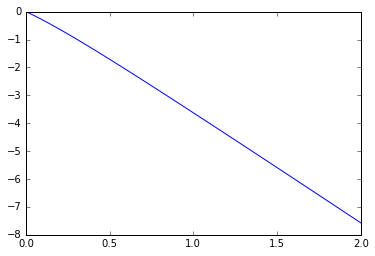

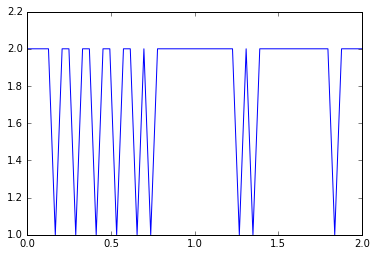

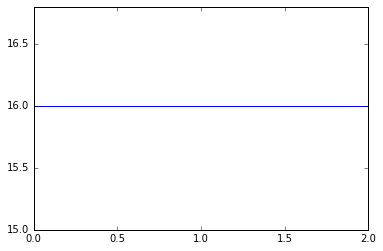

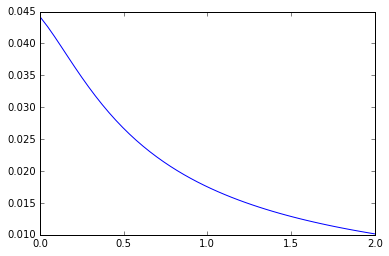

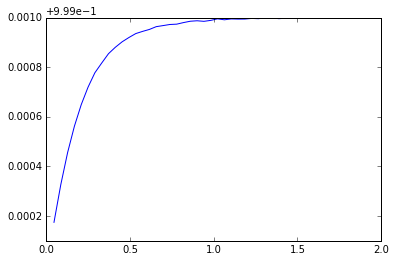

In [39]:
plt.plot(ts/2.0,energyMatrix)
plt.show()
plt.plot(ts/2.0,numbers)
plt.show()
plt.plot(ts/2.0,nFockMatrix)
plt.show()
plt.plot(ts/2.0,stdMatrix)
plt.show()

fidelities4=[]
for n in range(0,len(states)-1):
    fidelities4.append(fidelity(states[n],states[n+1]))
plt.plot(ts[1:]/2.0,fidelities4)
plt.show()

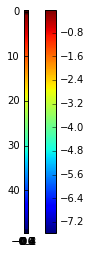

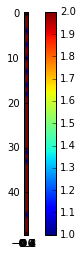

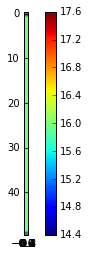

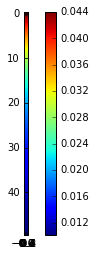

In [40]:
#print(energyMatrix)
plt.imshow(energyMatrix)
plt.colorbar()
plt.show()
#print(energyMatrix)
plt.imshow(numbers)
plt.colorbar()
plt.show()
#print(energyMatrix)
plt.imshow(nFockMatrix)
plt.colorbar()
plt.show()
#print(energyMatrix)
plt.imshow(stdMatrix)
plt.colorbar()
plt.show()

In [63]:
number_op = constructNumberOperator(8)
energyMatrix = np.zeros((N,M))
nFockMatrix = np.zeros((N,M))
stdMatrix = np.zeros((N,M))
states=[]
for n in range(0,N):
    for m in range(0,M):
        ops,coeffs,nqubits=constructSymbolicHubbard2(2,2,ts[n],Us[m])
        ham = getJWHamiltonian(coeffs, ops, nqubits)
        hamo=getHamiltonianObject(ham)
        eigenvals,eigenvecs=hamo.eigenstates()
        eigenvals2,eigenvecs2=pickSubspace(3,eigenvals,eigenvecs)
        arg = np.argmin(eigenvals2)
        energyMatrix[n,m]=eigenvals2[arg]
        entries, n_fock, std_state = getFockStateNumber(eigenvecs2[arg])
        states.append(eigenvecs2[arg])
        nFockMatrix[n,m] = n_fock
        stdMatrix[n,m] = std_state
        print(ts[n],int(expect(number_op,eigenvecs2[arg])),expect(hamo,eigenvecs2[arg]).real,eigenvals2[arg].real)
        #rho = eigenvecs2[arg]*eigenvecs2[arg].dag()
        #plt.bar(np.arange(0, 256)-.5, rho.diag())
        #plt.title("Distribution of states")
        #plt.show()
        #energyMatrix3[n,m]=min(eigenvals3)

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:14: ComplexWarning: Casting complex values to real discards the imaginary part


0.01 3 -0.010199980694763416 -0.0101999806948
0.0914285714286 3 -0.10800947955122907 -0.108009479551
0.172857142857 3 -0.23093009508748372 -0.230930095087
0.254285714286 3 -0.3761791640122718 -0.376179164012
0.335714285714 3 -0.5402126591026436 -0.540212659103
0.417142857143 3 -0.7194610406634098 -0.719461040663
0.498571428571 3 -0.910766126318117 -0.910766126318
0.58 3 -1.1115351859403857 -1.11153518594
0.661428571429 3 -1.3197262039375715 -1.31972620394
0.742857142857 3 -1.5337638925846582 -1.53376389258
0.824285714286 3 -1.75244229706432 -1.75244229706
0.905714285714 3 -1.974838132219754 -1.97483813222
0.987142857143 3 -2.200241156285451 -2.20024115629
1.06857142857 3 -2.4281009700781397 -2.42810097008
1.15 3 -2.6579872554379222 -2.65798725544
1.23142857143 3 -2.8895605301650544 -2.88956053017
1.31285714286 3 -3.1225502774559386 -3.12255027746
1.39428571429 3 -3.3567392408835737 -3.35673924088
1.47571428571 3 -3.5919509294732923 -3.59195092947
1.55714285714 3 -3.828041136921422 -3.8

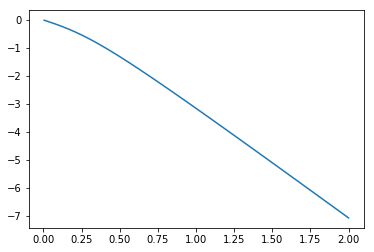

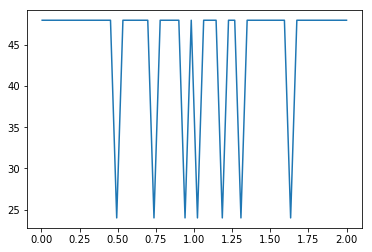

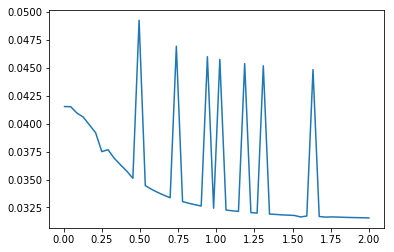

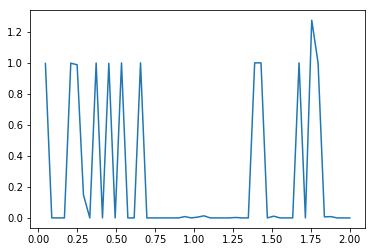

In [58]:
plt.plot(ts/2.0,energyMatrix)
plt.show()
plt.plot(ts/2.0,nFockMatrix)
plt.show()
plt.plot(ts/2.0,stdMatrix)
plt.show()

fidelities4=[]
for n in range(0,len(states)-1):
    fidelities4.append(fidelity(states[n],states[n+1]))
plt.plot(ts[1:]/2.0,fidelities4)
plt.show()